In [206]:
#!pip install tensorflow==1.13.1
#!pip install keras 2.2.4

In [73]:
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#import pymatgen

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
#from keras import backend as K
from tensorflow.keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation, multiply
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate


In [152]:
act_dict = {0: 'linear', 1: 'multiply', 2: 'sqrt', 3: '4rt'}
np.random.seed(100000)
weight_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,1.0,1)[0]}
bias_dict = {0: 0, 1: 1, 2: np.random.uniform(-0.001,0.001,1)[0]}
nact_terms = 5
nweight_terms = 20
nbias_terms = 5

In [153]:
df = pd.read_excel('ExpData.xlsx')
print (df.shape)

(152, 6)


In [170]:
df = df.round({'N_arb': 6, 'M_arb': 3, 'Q_arb': 3, 'Density [g/cc]': 3, 'D (exp) [km/s]': 3})
df['D_KJ [km/s]'] = np.around(1.01*np.sqrt(df['N_arb']*np.sqrt(df['M_arb'])*np.sqrt(df['Q_arb']))*(1+1.3*df['Density [g/cc]']),decimals=3)
df.head()

,Explosive,N_arb,M_arb,Q_arb,Density [g/cc],D (exp) [km/s],D_KJ [km/s]
0,"1,3,5-Triamino-2,4,6-trinitrobenzene",0.029070,27.200,1089.154,1.80,7.35,7.546
1,"1,3,5-Trinitrobenzene",0.024648,32.000,1351.177,1.71,7.30,7.370
2,"2,4,6,2',4',6'-Hexanitrodiphenylamine",0.024487,32.744,1368.752,1.60,7.20,7.083
3,"2,4,6-Trinitrocresol",0.025720,29.760,1216.919,1.62,6.85,6.940
4,"3-Nitro-1,2,4-triazole-5-one",0.030769,29.500,982.410,1.80,7.89,7.721


In [155]:
inputs = np.array(df[['N_arb','M_arb','Q_arb','Density [g/cc]']])

outputs = np.array(df['D (exp) [km/s]'])


print (inputs.shape, outputs.shape)

train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.2, random_state=0)
print (train_inputs.shape, train_outputs.shape)
print (test_inputs.shape, test_outputs.shape)

(152, 4) (152,)
(121, 4) (121,)
(31, 4) (31,)


In [156]:

def sqrt_act(x):
    return x**(1/2)

def frt_act(x):
    return x**(1/4)


In [157]:
class CustomDense(keras.layers.Layer):
    def __init__(self, num_units, input_num, activation, name, trainable_weight, trainable_bias):
        super(CustomDense, self).__init__()
        self.num_units = num_units
        self.activation = Activation(activation)
        self.trainable_weight = trainable_weight
        self.trainable_bias = trainable_bias
        self.name = name
        name_w = 'w'+self.name[1:]
        name_b = 'b'+self.name[1:]
        self.weight = self.add_weight(shape=(input_num, self.num_units), name=name_w, trainable=self.trainable_weight, initializer="zeros")
        self.bias = self.add_weight(shape=(self.num_units,), name=name_b, trainable=self.trainable_bias, initializer="zeros")
        
    def call(self, input):
        y = tf.matmul(input, self.weight) + self.bias
        y = self.activation(y)
        return y


In [158]:
def create_node(input1, input2, input3, input4, name, trainable1, trainable2, trainable3, trainable4, act, bias):
    base = name
    n1 = base + "1"
    n2 = base + "2"
    n3 = base + "3"
    n4 = base + "4"
    an1 = CustomDense(1, 1, activation = 'linear', name=n1, trainable_weight=trainable1, trainable_bias = 0) (input1)
    an2 = CustomDense(1, 1, activation = 'linear', name=n2, trainable_weight=trainable2, trainable_bias = 0) (input2)
    an3 = CustomDense(1, 1, activation = 'linear', name=n3, trainable_weight=trainable3, trainable_bias = 0) (input3)
    an4 = CustomDense(1, 1, activation = 'linear', name=n4, trainable_weight=trainable4, trainable_bias=bias) (input4)
    if (act == "multiply"):
        an = multiply([an1, an2, an3, an4])
    
    else:
        an = add([an1, an2, an3, an4])
        if (act == "4rt"):
            an = Activation(frt_act) (an)
        elif (act == "sqrt"):
            an = Activation(sqrt_act) (an)
        else:
            an = Activation(act) (an)
    return an

In [159]:
def create_model(x):
    #initializer = keras.initializers.RandomUniform(minval=-0.001, maxval=0.001, seed=0)
    bias_initial = keras.initializers.Zeros()

    trainable_list = []
    for i in range(nweight_terms):
        if (x[i+nact_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)
    
    for i in range(nbias_terms):
        if (x[i+nact_terms+nweight_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)

    input1 = Input(shape=(1,))
    input2 = Input(shape=(1,))
    input3 = Input(shape=(1,))
    input4 = Input(shape=(1,))

    a1 = create_node(input1, input2, input3, input4, "a1", trainable_list[0], trainable_list[1], trainable_list[2], trainable_list[3], act_dict[x[0]], trainable_list[20])
    a2 = create_node(input1, input2, input3, input4, "a2", trainable_list[4], trainable_list[5], trainable_list[6], trainable_list[7], act_dict[x[1]], trainable_list[21])
    a3 = create_node(input1, input2, input3, input4, "a3", trainable_list[8], trainable_list[9], trainable_list[10], trainable_list[11], act_dict[x[2]], trainable_list[22])
    a4 = create_node(input1, input2, input3, input4, "a4", trainable_list[12], trainable_list[13], trainable_list[14], trainable_list[15], act_dict[x[3]], trainable_list[23])

    output = create_node(a1, a2, a3, a4, "output", trainable_list[16], trainable_list[17], trainable_list[18], trainable_list[19], act_dict[x[4]], trainable_list[24])
   # output2 = create_node(a1, a2, a3, a4, "output2", trainable_list[20], trainable_list[21], trainable_list[22], trainable_list[23], act_dict[x[5]])

    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    layer_list = []
    for i in range(len(model.layers)):
        name = model.layers[i].name
        if ( ("activation" in name) or ("input" in name) or ("add" in name) or ("multiply" in name) ):
            continue
        else:
            layer_list.append(i)
    
    for i in range(len(layer_list)):
                
        #if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
         #   model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ) ] )
        #else:
         #   model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
        
        name = model.layers[layer_list[i]].name
        if (("a14" in name) or ("a24" in name) or ("a34" in name) or ("a44" in name) or ("output4" in name)):
        
            if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
                model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/5)]] ] ) ] )
            else:
                model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/5)]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
            
        else:
            model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ), np.array( [0.] ) ] )

    model.summary()

    return model, trainable_list

In [160]:
losses = []
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + ' Loss: ' + str(logs.get('loss')) + '                     \n')
        losses.append(logs.get('loss'))

def train(model, train_inputs, train_outputs, verbose=False):
    mae_es= keras.callbacks.EarlyStopping(monitor='val_loss', patience=500,
                                          min_delta=1e-5, verbose=1, mode='auto', restore_best_weights=True)

    EPOCHS = 20000 # Number of EPOCHS
    history = model.fit([train_inputs[:,0], train_inputs[:,1], train_inputs[:,2], train_inputs[:,3]], train_outputs, epochs=EPOCHS,
                        shuffle=False, batch_size=len(train_inputs), verbose = False, callbacks=[PrintEpNum(), mae_es],
                        validation_split=0.2)

    if verbose:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Sq Error')
        plt.plot(history.epoch, np.array(history.history['loss']),label='Training loss')
        plt.legend()
        plt.show()
    return history

In [161]:
def f3(w):
    return w

In [211]:
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0]  # kj
individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0]

#individual = [0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0] # p0.001

new_model, trainable = create_model(individual)


Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_74 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_75 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_76 (InputLayer)           (None, 1)            0                                            
___________________________________________________________________________________________

In [201]:
print ("Trainable: ", trainable)
#trainable = np.zeros(nweight_terms)
if (any(trainable) == True):
    train(new_model, train_inputs, train_outputs, verbose=False)
    
wt_bs = new_model.get_weights()
weight_list = []
bias_list = []

for weight in wt_bs:
    if (weight.shape == (1,1)):
        weight_list.append(weight[0])
    else:
        bias_list.append(weight[0])
weight_list = np.array(weight_list)  
weight_list = np.transpose(weight_list)
bias_list = np.array(bias_list)
print(weight_list)
print(bias_list)

Trainable:  [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False]
Current Epoch: 1 Loss: 50.67979049682617                     
Current Epoch: 2 Loss: 50.665771484375                     
Current Epoch: 3 Loss: 50.65175247192383                     
Current Epoch: 4 Loss: 50.63774490356445                     
Current Epoch: 5 Loss: 50.62372970581055                     
Current Epoch: 6 Loss: 50.60972595214844                     
Current Epoch: 7 Loss: 50.595706939697266                     
Current Epoch: 8 Loss: 50.58170700073242                     
Current Epoch: 9 Loss: 50.56770706176758                     
Current Epoch: 10 Loss: 50.5536994934082                     
Current Epoch: 11 Loss: 50.53969955444336                     
Current Epoch: 12 Loss: 50.52570724487305                     
Current Epoch: 13 Loss: 50.5117073059082                     
Curren

Current Epoch: 128 Loss: 48.92120361328125                     
Current Epoch: 129 Loss: 48.90754318237305                     
Current Epoch: 130 Loss: 48.89388656616211                     
Current Epoch: 131 Loss: 48.88022994995117                     
Current Epoch: 132 Loss: 48.8665771484375                     
Current Epoch: 133 Loss: 48.85292434692383                     
Current Epoch: 134 Loss: 48.83928298950195                     
Current Epoch: 135 Loss: 48.82563781738281                     
Current Epoch: 136 Loss: 48.81199645996094                     
Current Epoch: 137 Loss: 48.79835891723633                     
Current Epoch: 138 Loss: 48.78472900390625                     
Current Epoch: 139 Loss: 48.77109146118164                     
Current Epoch: 140 Loss: 48.75746536254883                     
Current Epoch: 141 Loss: 48.74383544921875                     
Current Epoch: 142 Loss: 48.7302131652832                     
Current Epoch: 143 Loss: 48.71659851074219

Current Epoch: 256 Loss: 47.196136474609375                     
Current Epoch: 257 Loss: 47.18284606933594                     
Current Epoch: 258 Loss: 47.1695671081543                     
Current Epoch: 259 Loss: 47.15627670288086                     
Current Epoch: 260 Loss: 47.14298629760742                     
Current Epoch: 261 Loss: 47.12971115112305                     
Current Epoch: 262 Loss: 47.11643600463867                     
Current Epoch: 263 Loss: 47.103153228759766                     
Current Epoch: 264 Loss: 47.08988571166992                     
Current Epoch: 265 Loss: 47.07661056518555                     
Current Epoch: 266 Loss: 47.0633430480957                     
Current Epoch: 267 Loss: 47.050079345703125                     
Current Epoch: 268 Loss: 47.03682327270508                     
Current Epoch: 269 Loss: 47.0235595703125                     
Current Epoch: 270 Loss: 47.010311126708984                     
Current Epoch: 271 Loss: 46.99705123901

Current Epoch: 385 Loss: 45.504638671875                     
Current Epoch: 386 Loss: 45.4917106628418                     
Current Epoch: 387 Loss: 45.478790283203125                     
Current Epoch: 388 Loss: 45.46586227416992                     
Current Epoch: 389 Loss: 45.452938079833984                     
Current Epoch: 390 Loss: 45.44001388549805                     
Current Epoch: 391 Loss: 45.427093505859375                     
Current Epoch: 392 Loss: 45.4141845703125                     
Current Epoch: 393 Loss: 45.40126419067383                     
Current Epoch: 394 Loss: 45.38835525512695                     
Current Epoch: 395 Loss: 45.37544631958008                     
Current Epoch: 396 Loss: 45.362548828125                     
Current Epoch: 397 Loss: 45.34965133666992                     
Current Epoch: 398 Loss: 45.33675003051758                     
Current Epoch: 399 Loss: 45.3238525390625                     
Current Epoch: 400 Loss: 45.31096267700195  

Current Epoch: 514 Loss: 43.85905456542969                     
Current Epoch: 515 Loss: 43.84647750854492                     
Current Epoch: 516 Loss: 43.83390426635742                     
Current Epoch: 517 Loss: 43.82131576538086                     
Current Epoch: 518 Loss: 43.808746337890625                     
Current Epoch: 519 Loss: 43.796173095703125                     
Current Epoch: 520 Loss: 43.78361129760742                     
Current Epoch: 521 Loss: 43.77103805541992                     
Current Epoch: 522 Loss: 43.75848388671875                     
Current Epoch: 523 Loss: 43.74592208862305                     
Current Epoch: 524 Loss: 43.733367919921875                     
Current Epoch: 525 Loss: 43.7208137512207                     
Current Epoch: 526 Loss: 43.7082633972168                     
Current Epoch: 527 Loss: 43.69572067260742                     
Current Epoch: 528 Loss: 43.68316650390625                     
Current Epoch: 529 Loss: 43.67062759399

Current Epoch: 642 Loss: 42.27035140991211                     
Current Epoch: 643 Loss: 42.25810623168945                     
Current Epoch: 644 Loss: 42.24586868286133                     
Current Epoch: 645 Loss: 42.2336311340332                     
Current Epoch: 646 Loss: 42.221397399902344                     
Current Epoch: 647 Loss: 42.20916748046875                     
Current Epoch: 648 Loss: 42.19694137573242                     
Current Epoch: 649 Loss: 42.18471145629883                     
Current Epoch: 650 Loss: 42.172489166259766                     
Current Epoch: 651 Loss: 42.1602668762207                     
Current Epoch: 652 Loss: 42.14805221557617                     
Current Epoch: 653 Loss: 42.13583755493164                     
Current Epoch: 654 Loss: 42.123619079589844                     
Current Epoch: 655 Loss: 42.11140441894531                     
Current Epoch: 656 Loss: 42.09920120239258                     
Current Epoch: 657 Loss: 42.08700180053

Current Epoch: 770 Loss: 40.72441482543945                     
Current Epoch: 771 Loss: 40.71250534057617                     
Current Epoch: 772 Loss: 40.700592041015625                     
Current Epoch: 773 Loss: 40.68868637084961                     
Current Epoch: 774 Loss: 40.676780700683594                     
Current Epoch: 775 Loss: 40.66487503051758                     
Current Epoch: 776 Loss: 40.65298080444336                     
Current Epoch: 777 Loss: 40.641082763671875                     
Current Epoch: 778 Loss: 40.629188537597656                     
Current Epoch: 779 Loss: 40.61729431152344                     
Current Epoch: 780 Loss: 40.605403900146484                     
Current Epoch: 781 Loss: 40.59352493286133                     
Current Epoch: 782 Loss: 40.581634521484375                     
Current Epoch: 783 Loss: 40.56975173950195                     
Current Epoch: 784 Loss: 40.55787658691406                     
Current Epoch: 785 Loss: 40.546001

Current Epoch: 898 Loss: 39.220157623291016                     
Current Epoch: 899 Loss: 39.20856857299805                     
Current Epoch: 900 Loss: 39.19697952270508                     
Current Epoch: 901 Loss: 39.185394287109375                     
Current Epoch: 902 Loss: 39.17381286621094                     
Current Epoch: 903 Loss: 39.1622314453125                     
Current Epoch: 904 Loss: 39.15065002441406                     
Current Epoch: 905 Loss: 39.13908004760742                     
Current Epoch: 906 Loss: 39.127506256103516                     
Current Epoch: 907 Loss: 39.11592483520508                     
Current Epoch: 908 Loss: 39.1043586730957                     
Current Epoch: 909 Loss: 39.092796325683594                     
Current Epoch: 910 Loss: 39.08123779296875                     
Current Epoch: 911 Loss: 39.06967544555664                     
Current Epoch: 912 Loss: 39.058109283447266                     
Current Epoch: 913 Loss: 39.046554565

Current Epoch: 1026 Loss: 37.75650405883789                     
Current Epoch: 1027 Loss: 37.7452278137207                     
Current Epoch: 1028 Loss: 37.733951568603516                     
Current Epoch: 1029 Loss: 37.72268295288086                     
Current Epoch: 1030 Loss: 37.7114143371582                     
Current Epoch: 1031 Loss: 37.70014572143555                     
Current Epoch: 1032 Loss: 37.68888473510742                     
Current Epoch: 1033 Loss: 37.6776123046875                     
Current Epoch: 1034 Loss: 37.66635513305664                     
Current Epoch: 1035 Loss: 37.65509796142578                     
Current Epoch: 1036 Loss: 37.64384460449219                     
Current Epoch: 1037 Loss: 37.63258743286133                     
Current Epoch: 1038 Loss: 37.621334075927734                     
Current Epoch: 1039 Loss: 37.61008834838867                     
Current Epoch: 1040 Loss: 37.598838806152344                     
Current Epoch: 1041 Loss:

Current Epoch: 1152 Loss: 36.35440444946289                     
Current Epoch: 1153 Loss: 36.34342575073242                     
Current Epoch: 1154 Loss: 36.33245086669922                     
Current Epoch: 1155 Loss: 36.32147979736328                     
Current Epoch: 1156 Loss: 36.310508728027344                     
Current Epoch: 1157 Loss: 36.29954147338867                     
Current Epoch: 1158 Loss: 36.288578033447266                     
Current Epoch: 1159 Loss: 36.27761459350586                     
Current Epoch: 1160 Loss: 36.266658782958984                     
Current Epoch: 1161 Loss: 36.25569534301758                     
Current Epoch: 1162 Loss: 36.2447395324707                     
Current Epoch: 1163 Loss: 36.23378372192383                     
Current Epoch: 1164 Loss: 36.22283935546875                     
Current Epoch: 1165 Loss: 36.21188735961914                     
Current Epoch: 1166 Loss: 36.20094299316406                     
Current Epoch: 1167 Los

Current Epoch: 1278 Loss: 34.98975372314453                     
Current Epoch: 1279 Loss: 34.97907257080078                     
Current Epoch: 1280 Loss: 34.968387603759766                     
Current Epoch: 1281 Loss: 34.957706451416016                     
Current Epoch: 1282 Loss: 34.9470329284668                     
Current Epoch: 1283 Loss: 34.93636703491211                     
Current Epoch: 1284 Loss: 34.92568588256836                     
Current Epoch: 1285 Loss: 34.91501998901367                     
Current Epoch: 1286 Loss: 34.904354095458984                     
Current Epoch: 1287 Loss: 34.893680572509766                     
Current Epoch: 1288 Loss: 34.88302230834961                     
Current Epoch: 1289 Loss: 34.87236404418945                     
Current Epoch: 1290 Loss: 34.8617057800293                     
Current Epoch: 1291 Loss: 34.85105514526367                     
Current Epoch: 1292 Loss: 34.84040069580078                     
Current Epoch: 1293 Los

Current Epoch: 1404 Loss: 33.66168975830078                     
Current Epoch: 1405 Loss: 33.65129089355469                     
Current Epoch: 1406 Loss: 33.640899658203125                     
Current Epoch: 1407 Loss: 33.6305046081543                     
Current Epoch: 1408 Loss: 33.620113372802734                     
Current Epoch: 1409 Loss: 33.6097297668457                     
Current Epoch: 1410 Loss: 33.59934616088867                     
Current Epoch: 1411 Loss: 33.58896255493164                     
Current Epoch: 1412 Loss: 33.578582763671875                     
Current Epoch: 1413 Loss: 33.56820297241211                     
Current Epoch: 1414 Loss: 33.55782699584961                     
Current Epoch: 1415 Loss: 33.54745101928711                     
Current Epoch: 1416 Loss: 33.53708267211914                     
Current Epoch: 1417 Loss: 33.52671432495117                     
Current Epoch: 1418 Loss: 33.5163459777832                     
Current Epoch: 1419 Loss:

Current Epoch: 1530 Loss: 32.36937713623047                     
Current Epoch: 1531 Loss: 32.3592643737793                     
Current Epoch: 1532 Loss: 32.349151611328125                     
Current Epoch: 1533 Loss: 32.33903884887695                     
Current Epoch: 1534 Loss: 32.32892990112305                     
Current Epoch: 1535 Loss: 32.31882095336914                     
Current Epoch: 1536 Loss: 32.3087158203125                     
Current Epoch: 1537 Loss: 32.298614501953125                     
Current Epoch: 1538 Loss: 32.288516998291016                     
Current Epoch: 1539 Loss: 32.27841567993164                     
Current Epoch: 1540 Loss: 32.2683219909668                     
Current Epoch: 1541 Loss: 32.25822830200195                     
Current Epoch: 1542 Loss: 32.248138427734375                     
Current Epoch: 1543 Loss: 32.2380485534668                     
Current Epoch: 1544 Loss: 32.227962493896484                     
Current Epoch: 1545 Loss

Current Epoch: 1656 Loss: 31.11204719543457                     
Current Epoch: 1657 Loss: 31.102209091186523                     
Current Epoch: 1658 Loss: 31.092369079589844                     
Current Epoch: 1659 Loss: 31.082534790039062                     
Current Epoch: 1660 Loss: 31.072694778442383                     
Current Epoch: 1661 Loss: 31.0628662109375                     
Current Epoch: 1662 Loss: 31.053037643432617                     
Current Epoch: 1663 Loss: 31.043210983276367                     
Current Epoch: 1664 Loss: 31.03338050842285                     
Current Epoch: 1665 Loss: 31.0235595703125                     
Current Epoch: 1666 Loss: 31.013734817504883                     
Current Epoch: 1667 Loss: 31.003915786743164                     
Current Epoch: 1668 Loss: 30.99410057067871                     
Current Epoch: 1669 Loss: 30.984285354614258                     
Current Epoch: 1670 Loss: 30.974472045898438                     
Current Epoch: 16

Current Epoch: 1781 Loss: 29.898527145385742                     
Current Epoch: 1782 Loss: 29.888952255249023                     
Current Epoch: 1783 Loss: 29.879379272460938                     
Current Epoch: 1784 Loss: 29.869810104370117                     
Current Epoch: 1785 Loss: 29.86024284362793                     
Current Epoch: 1786 Loss: 29.850675582885742                     
Current Epoch: 1787 Loss: 29.841110229492188                     
Current Epoch: 1788 Loss: 29.831552505493164                     
Current Epoch: 1789 Loss: 29.821990966796875                     
Current Epoch: 1790 Loss: 29.81243133544922                     
Current Epoch: 1791 Loss: 29.802879333496094                     
Current Epoch: 1792 Loss: 29.79332160949707                     
Current Epoch: 1793 Loss: 29.783775329589844                     
Current Epoch: 1794 Loss: 29.77422523498535                     
Current Epoch: 1795 Loss: 29.764680862426758                     
Current Epoch:

Current Epoch: 1906 Loss: 28.718008041381836                     
Current Epoch: 1907 Loss: 28.708694458007812                     
Current Epoch: 1908 Loss: 28.69938087463379                     
Current Epoch: 1909 Loss: 28.69007682800293                     
Current Epoch: 1910 Loss: 28.680770874023438                     
Current Epoch: 1911 Loss: 28.671463012695312                     
Current Epoch: 1912 Loss: 28.662160873413086                     
Current Epoch: 1913 Loss: 28.652862548828125                     
Current Epoch: 1914 Loss: 28.64356231689453                     
Current Epoch: 1915 Loss: 28.634267807006836                     
Current Epoch: 1916 Loss: 28.624975204467773                     
Current Epoch: 1917 Loss: 28.615676879882812                     
Current Epoch: 1918 Loss: 28.60638427734375                     
Current Epoch: 1919 Loss: 28.59710121154785                     
Current Epoch: 1920 Loss: 28.587814331054688                     
Current Epoch: 

Current Epoch: 2032 Loss: 27.5607852935791                     
Current Epoch: 2033 Loss: 27.551729202270508                     
Current Epoch: 2034 Loss: 27.542673110961914                     
Current Epoch: 2035 Loss: 27.53362464904785                     
Current Epoch: 2036 Loss: 27.52457618713379                     
Current Epoch: 2037 Loss: 27.515533447265625                     
Current Epoch: 2038 Loss: 27.506484985351562                     
Current Epoch: 2039 Loss: 27.497446060180664                     
Current Epoch: 2040 Loss: 27.4884033203125                     
Current Epoch: 2041 Loss: 27.4793643951416                     
Current Epoch: 2042 Loss: 27.4703311920166                     
Current Epoch: 2043 Loss: 27.461294174194336                     
Current Epoch: 2044 Loss: 27.45226287841797                     
Current Epoch: 2045 Loss: 27.4432315826416                     
Current Epoch: 2046 Loss: 27.4342041015625                     
Current Epoch: 2047 Loss:

Current Epoch: 2158 Loss: 26.4357967376709                     
Current Epoch: 2159 Loss: 26.42699432373047                     
Current Epoch: 2160 Loss: 26.418195724487305                     
Current Epoch: 2161 Loss: 26.409400939941406                     
Current Epoch: 2162 Loss: 26.400604248046875                     
Current Epoch: 2163 Loss: 26.391809463500977                     
Current Epoch: 2164 Loss: 26.383020401000977                     
Current Epoch: 2165 Loss: 26.37422752380371                     
Current Epoch: 2166 Loss: 26.365446090698242                     
Current Epoch: 2167 Loss: 26.356658935546875                     
Current Epoch: 2168 Loss: 26.347871780395508                     
Current Epoch: 2169 Loss: 26.339094161987305                     
Current Epoch: 2170 Loss: 26.330312728881836                     
Current Epoch: 2171 Loss: 26.3215389251709                     
Current Epoch: 2172 Loss: 26.312759399414062                     
Current Epoch: 2

Current Epoch: 2284 Loss: 25.342437744140625                     
Current Epoch: 2285 Loss: 25.333887100219727                     
Current Epoch: 2286 Loss: 25.32533836364746                     
Current Epoch: 2287 Loss: 25.316787719726562                     
Current Epoch: 2288 Loss: 25.308242797851562                     
Current Epoch: 2289 Loss: 25.299697875976562                     
Current Epoch: 2290 Loss: 25.29115867614746                     
Current Epoch: 2291 Loss: 25.28261375427246                     
Current Epoch: 2292 Loss: 25.274072647094727                     
Current Epoch: 2293 Loss: 25.265539169311523                     
Current Epoch: 2294 Loss: 25.25700569152832                     
Current Epoch: 2295 Loss: 25.24846839904785                     
Current Epoch: 2296 Loss: 25.239938735961914                     
Current Epoch: 2297 Loss: 25.231414794921875                     
Current Epoch: 2298 Loss: 25.222883224487305                     
Current Epoch: 

Current Epoch: 2410 Loss: 24.28014373779297                     
Current Epoch: 2411 Loss: 24.271835327148438                     
Current Epoch: 2412 Loss: 24.26352882385254                     
Current Epoch: 2413 Loss: 24.255224227905273                     
Current Epoch: 2414 Loss: 24.246919631958008                     
Current Epoch: 2415 Loss: 24.238622665405273                     
Current Epoch: 2416 Loss: 24.230321884155273                     
Current Epoch: 2417 Loss: 24.22202491760254                     
Current Epoch: 2418 Loss: 24.213729858398438                     
Current Epoch: 2419 Loss: 24.2054386138916                     
Current Epoch: 2420 Loss: 24.1971435546875                     
Current Epoch: 2421 Loss: 24.18885612487793                     
Current Epoch: 2422 Loss: 24.180566787719727                     
Current Epoch: 2423 Loss: 24.172286987304688                     
Current Epoch: 2424 Loss: 24.16400146484375                     
Current Epoch: 2425

Current Epoch: 2535 Loss: 23.256431579589844                     
Current Epoch: 2536 Loss: 23.248361587524414                     
Current Epoch: 2537 Loss: 23.240293502807617                     
Current Epoch: 2538 Loss: 23.232229232788086                     
Current Epoch: 2539 Loss: 23.22416114807129                     
Current Epoch: 2540 Loss: 23.216100692749023                     
Current Epoch: 2541 Loss: 23.208038330078125                     
Current Epoch: 2542 Loss: 23.199981689453125                     
Current Epoch: 2543 Loss: 23.191923141479492                     
Current Epoch: 2544 Loss: 23.183868408203125                     
Current Epoch: 2545 Loss: 23.175819396972656                     
Current Epoch: 2546 Loss: 23.16776466369629                     
Current Epoch: 2547 Loss: 23.159719467163086                     
Current Epoch: 2548 Loss: 23.15166664123535                     
Current Epoch: 2549 Loss: 23.143625259399414                     
Current Epoch

Current Epoch: 2660 Loss: 22.262245178222656                     
Current Epoch: 2661 Loss: 22.25440788269043                     
Current Epoch: 2662 Loss: 22.24657440185547                     
Current Epoch: 2663 Loss: 22.238739013671875                     
Current Epoch: 2664 Loss: 22.230911254882812                     
Current Epoch: 2665 Loss: 22.223081588745117                     
Current Epoch: 2666 Loss: 22.215255737304688                     
Current Epoch: 2667 Loss: 22.207433700561523                     
Current Epoch: 2668 Loss: 22.199609756469727                     
Current Epoch: 2669 Loss: 22.191787719726562                     
Current Epoch: 2670 Loss: 22.1839656829834                     
Current Epoch: 2671 Loss: 22.176149368286133                     
Current Epoch: 2672 Loss: 22.1683349609375                     
Current Epoch: 2673 Loss: 22.160524368286133                     
Current Epoch: 2674 Loss: 22.152711868286133                     
Current Epoch: 2

Current Epoch: 2786 Loss: 21.289487838745117                     
Current Epoch: 2787 Loss: 21.28188705444336                     
Current Epoch: 2788 Loss: 21.27428436279297                     
Current Epoch: 2789 Loss: 21.266685485839844                     
Current Epoch: 2790 Loss: 21.25908851623535                     
Current Epoch: 2791 Loss: 21.251489639282227                     
Current Epoch: 2792 Loss: 21.243896484375                     
Current Epoch: 2793 Loss: 21.236303329467773                     
Current Epoch: 2794 Loss: 21.228715896606445                     
Current Epoch: 2795 Loss: 21.22112464904785                     
Current Epoch: 2796 Loss: 21.213537216186523                     
Current Epoch: 2797 Loss: 21.205951690673828                     
Current Epoch: 2798 Loss: 21.198368072509766                     
Current Epoch: 2799 Loss: 21.190786361694336                     
Current Epoch: 2800 Loss: 21.183210372924805                     
Current Epoch: 28

Current Epoch: 2911 Loss: 20.353151321411133                     
Current Epoch: 2912 Loss: 20.345779418945312                     
Current Epoch: 2913 Loss: 20.338401794433594                     
Current Epoch: 2914 Loss: 20.331029891967773                     
Current Epoch: 2915 Loss: 20.323654174804688                     
Current Epoch: 2916 Loss: 20.316287994384766                     
Current Epoch: 2917 Loss: 20.30891990661621                     
Current Epoch: 2918 Loss: 20.301551818847656                     
Current Epoch: 2919 Loss: 20.294187545776367                     
Current Epoch: 2920 Loss: 20.28682518005371                     
Current Epoch: 2921 Loss: 20.27946662902832                     
Current Epoch: 2922 Loss: 20.27210807800293                     
Current Epoch: 2923 Loss: 20.26474952697754                     
Current Epoch: 2924 Loss: 20.257394790649414                     
Current Epoch: 2925 Loss: 20.250043869018555                     
Current Epoch: 

Current Epoch: 3036 Loss: 19.444950103759766                     
Current Epoch: 3037 Loss: 19.43779754638672                     
Current Epoch: 3038 Loss: 19.430646896362305                     
Current Epoch: 3039 Loss: 19.423498153686523                     
Current Epoch: 3040 Loss: 19.416349411010742                     
Current Epoch: 3041 Loss: 19.409204483032227                     
Current Epoch: 3042 Loss: 19.40205955505371                     
Current Epoch: 3043 Loss: 19.394912719726562                     
Current Epoch: 3044 Loss: 19.387773513793945                     
Current Epoch: 3045 Loss: 19.38063621520996                     
Current Epoch: 3046 Loss: 19.373498916625977                     
Current Epoch: 3047 Loss: 19.366363525390625                     
Current Epoch: 3048 Loss: 19.359228134155273                     
Current Epoch: 3049 Loss: 19.352096557617188                     
Current Epoch: 3050 Loss: 19.344968795776367                     
Current Epoch

Current Epoch: 3161 Loss: 18.56446647644043                     
Current Epoch: 3162 Loss: 18.557533264160156                     
Current Epoch: 3163 Loss: 18.550601959228516                     
Current Epoch: 3164 Loss: 18.543672561645508                     
Current Epoch: 3165 Loss: 18.5367431640625                     
Current Epoch: 3166 Loss: 18.529817581176758                     
Current Epoch: 3167 Loss: 18.52289581298828                     
Current Epoch: 3168 Loss: 18.515974044799805                     
Current Epoch: 3169 Loss: 18.509050369262695                     
Current Epoch: 3170 Loss: 18.50213050842285                     
Current Epoch: 3171 Loss: 18.495214462280273                     
Current Epoch: 3172 Loss: 18.488298416137695                     
Current Epoch: 3173 Loss: 18.48138427734375                     
Current Epoch: 3174 Loss: 18.47447395324707                     
Current Epoch: 3175 Loss: 18.467561721801758                     
Current Epoch: 31

Current Epoch: 3286 Loss: 17.71129035949707                     
Current Epoch: 3287 Loss: 17.70457649230957                     
Current Epoch: 3288 Loss: 17.697860717773438                     
Current Epoch: 3289 Loss: 17.691146850585938                     
Current Epoch: 3290 Loss: 17.684438705444336                     
Current Epoch: 3291 Loss: 17.6777286529541                     
Current Epoch: 3292 Loss: 17.6710205078125                     
Current Epoch: 3293 Loss: 17.66431427001953                     
Current Epoch: 3294 Loss: 17.657609939575195                     
Current Epoch: 3295 Loss: 17.650907516479492                     
Current Epoch: 3296 Loss: 17.644208908081055                     
Current Epoch: 3297 Loss: 17.637508392333984                     
Current Epoch: 3298 Loss: 17.63081169128418                     
Current Epoch: 3299 Loss: 17.624114990234375                     
Current Epoch: 3300 Loss: 17.617422103881836                     
Current Epoch: 330

Current Epoch: 3411 Loss: 16.885038375854492                     
Current Epoch: 3412 Loss: 16.8785343170166                     
Current Epoch: 3413 Loss: 16.872034072875977                     
Current Epoch: 3414 Loss: 16.865535736083984                     
Current Epoch: 3415 Loss: 16.859037399291992                     
Current Epoch: 3416 Loss: 16.852540969848633                     
Current Epoch: 3417 Loss: 16.84604835510254                     
Current Epoch: 3418 Loss: 16.839555740356445                     
Current Epoch: 3419 Loss: 16.83306312561035                     
Current Epoch: 3420 Loss: 16.826576232910156                     
Current Epoch: 3421 Loss: 16.82008934020996                     
Current Epoch: 3422 Loss: 16.813600540161133                     
Current Epoch: 3423 Loss: 16.807119369506836                     
Current Epoch: 3424 Loss: 16.800634384155273                     
Current Epoch: 3425 Loss: 16.794157028198242                     
Current Epoch: 

Current Epoch: 3536 Loss: 16.085325241088867                     
Current Epoch: 3537 Loss: 16.07903480529785                     
Current Epoch: 3538 Loss: 16.072744369506836                     
Current Epoch: 3539 Loss: 16.066457748413086                     
Current Epoch: 3540 Loss: 16.06016731262207                     
Current Epoch: 3541 Loss: 16.053884506225586                     
Current Epoch: 3542 Loss: 16.0476016998291                     
Current Epoch: 3543 Loss: 16.041318893432617                     
Current Epoch: 3544 Loss: 16.0350399017334                     
Current Epoch: 3545 Loss: 16.02876091003418                     
Current Epoch: 3546 Loss: 16.02248191833496                     
Current Epoch: 3547 Loss: 16.016210556030273                     
Current Epoch: 3548 Loss: 16.00993537902832                     
Current Epoch: 3549 Loss: 16.003664016723633                     
Current Epoch: 3550 Loss: 15.997395515441895                     
Current Epoch: 3551

Current Epoch: 3661 Loss: 15.31179428100586                     
Current Epoch: 3662 Loss: 15.305710792541504                     
Current Epoch: 3663 Loss: 15.299629211425781                     
Current Epoch: 3664 Loss: 15.293548583984375                     
Current Epoch: 3665 Loss: 15.287470817565918                     
Current Epoch: 3666 Loss: 15.281392097473145                     
Current Epoch: 3667 Loss: 15.275315284729004                     
Current Epoch: 3668 Loss: 15.269245147705078                     
Current Epoch: 3669 Loss: 15.26317310333252                     
Current Epoch: 3670 Loss: 15.257102966308594                     
Current Epoch: 3671 Loss: 15.251030921936035                     
Current Epoch: 3672 Loss: 15.244965553283691                     
Current Epoch: 3673 Loss: 15.238900184631348                     
Current Epoch: 3674 Loss: 15.232837677001953                     
Current Epoch: 3675 Loss: 15.226773262023926                     
Current Epoc

Current Epoch: 3786 Loss: 14.56408977508545                     
Current Epoch: 3787 Loss: 14.558212280273438                     
Current Epoch: 3788 Loss: 14.552336692810059                     
Current Epoch: 3789 Loss: 14.546460151672363                     
Current Epoch: 3790 Loss: 14.5405855178833                     
Current Epoch: 3791 Loss: 14.534716606140137                     
Current Epoch: 3792 Loss: 14.528843879699707                     
Current Epoch: 3793 Loss: 14.52297592163086                     
Current Epoch: 3794 Loss: 14.517107963562012                     
Current Epoch: 3795 Loss: 14.511242866516113                     
Current Epoch: 3796 Loss: 14.505378723144531                     
Current Epoch: 3797 Loss: 14.499515533447266                     
Current Epoch: 3798 Loss: 14.493657112121582                     
Current Epoch: 3799 Loss: 14.487799644470215                     
Current Epoch: 3800 Loss: 14.481941223144531                     
Current Epoch:

Current Epoch: 3911 Loss: 13.841865539550781                     
Current Epoch: 3912 Loss: 13.836189270019531                     
Current Epoch: 3913 Loss: 13.830516815185547                     
Current Epoch: 3914 Loss: 13.824843406677246                     
Current Epoch: 3915 Loss: 13.819172859191895                     
Current Epoch: 3916 Loss: 13.813499450683594                     
Current Epoch: 3917 Loss: 13.807833671569824                     
Current Epoch: 3918 Loss: 13.802166938781738                     
Current Epoch: 3919 Loss: 13.796504020690918                     
Current Epoch: 3920 Loss: 13.790839195251465                     
Current Epoch: 3921 Loss: 13.785176277160645                     
Current Epoch: 3922 Loss: 13.779518127441406                     
Current Epoch: 3923 Loss: 13.773859977722168                     
Current Epoch: 3924 Loss: 13.768203735351562                     
Current Epoch: 3925 Loss: 13.762547492980957                     
Current Ep

Current Epoch: 4036 Loss: 13.14478588104248                     
Current Epoch: 4037 Loss: 13.139307975769043                     
Current Epoch: 4038 Loss: 13.133835792541504                     
Current Epoch: 4039 Loss: 13.128361701965332                     
Current Epoch: 4040 Loss: 13.122891426086426                     
Current Epoch: 4041 Loss: 13.117423057556152                     
Current Epoch: 4042 Loss: 13.111953735351562                     
Current Epoch: 4043 Loss: 13.106486320495605                     
Current Epoch: 4044 Loss: 13.10102367401123                     
Current Epoch: 4045 Loss: 13.095558166503906                     
Current Epoch: 4046 Loss: 13.090096473693848                     
Current Epoch: 4047 Loss: 13.084635734558105                     
Current Epoch: 4048 Loss: 13.079174995422363                     
Current Epoch: 4049 Loss: 13.073719024658203                     
Current Epoch: 4050 Loss: 13.068264961242676                     
Current Epoc

Current Epoch: 4161 Loss: 12.472519874572754                     
Current Epoch: 4162 Loss: 12.467239379882812                     
Current Epoch: 4163 Loss: 12.461962699890137                     
Current Epoch: 4164 Loss: 12.456686973571777                     
Current Epoch: 4165 Loss: 12.451412200927734                     
Current Epoch: 4166 Loss: 12.446139335632324                     
Current Epoch: 4167 Loss: 12.44086742401123                     
Current Epoch: 4168 Loss: 12.43559741973877                     
Current Epoch: 4169 Loss: 12.430331230163574                     
Current Epoch: 4170 Loss: 12.425064086914062                     
Current Epoch: 4171 Loss: 12.4197998046875                     
Current Epoch: 4172 Loss: 12.414535522460938                     
Current Epoch: 4173 Loss: 12.40927505493164                     
Current Epoch: 4174 Loss: 12.40401554107666                     
Current Epoch: 4175 Loss: 12.398757934570312                     
Current Epoch: 4

Current Epoch: 4286 Loss: 11.824740409851074                     
Current Epoch: 4287 Loss: 11.819652557373047                     
Current Epoch: 4288 Loss: 11.814570426940918                     
Current Epoch: 4289 Loss: 11.809489250183105                     
Current Epoch: 4290 Loss: 11.804409980773926                     
Current Epoch: 4291 Loss: 11.799332618713379                     
Current Epoch: 4292 Loss: 11.794255256652832                     
Current Epoch: 4293 Loss: 11.78918170928955                     
Current Epoch: 4294 Loss: 11.78410816192627                     
Current Epoch: 4295 Loss: 11.779034614562988                     
Current Epoch: 4296 Loss: 11.773964881896973                     
Current Epoch: 4297 Loss: 11.768895149230957                     
Current Epoch: 4298 Loss: 11.763827323913574                     
Current Epoch: 4299 Loss: 11.758759498596191                     
Current Epoch: 4300 Loss: 11.75369644165039                     
Current Epoch

Current Epoch: 4411 Loss: 11.20112133026123                     
Current Epoch: 4412 Loss: 11.19622802734375                     
Current Epoch: 4413 Loss: 11.19133472442627                     
Current Epoch: 4414 Loss: 11.186450004577637                     
Current Epoch: 4415 Loss: 11.181561470031738                     
Current Epoch: 4416 Loss: 11.176674842834473                     
Current Epoch: 4417 Loss: 11.171791076660156                     
Current Epoch: 4418 Loss: 11.166908264160156                     
Current Epoch: 4419 Loss: 11.162026405334473                     
Current Epoch: 4420 Loss: 11.157147407531738                     
Current Epoch: 4421 Loss: 11.152267456054688                     
Current Epoch: 4422 Loss: 11.14738941192627                     
Current Epoch: 4423 Loss: 11.1425142288208                     
Current Epoch: 4424 Loss: 11.1376371383667                     
Current Epoch: 4425 Loss: 11.132766723632812                     
Current Epoch: 442

Current Epoch: 4536 Loss: 10.601347923278809                     
Current Epoch: 4537 Loss: 10.59664535522461                     
Current Epoch: 4538 Loss: 10.59194564819336                     
Current Epoch: 4539 Loss: 10.58724594116211                     
Current Epoch: 4540 Loss: 10.582547187805176                     
Current Epoch: 4541 Loss: 10.577850341796875                     
Current Epoch: 4542 Loss: 10.573156356811523                     
Current Epoch: 4543 Loss: 10.568461418151855                     
Current Epoch: 4544 Loss: 10.563767433166504                     
Current Epoch: 4545 Loss: 10.559075355529785                     
Current Epoch: 4546 Loss: 10.5543851852417                     
Current Epoch: 4547 Loss: 10.549698829650879                     
Current Epoch: 4548 Loss: 10.545013427734375                     
Current Epoch: 4549 Loss: 10.540328979492188                     
Current Epoch: 4550 Loss: 10.53564739227295                     
Current Epoch: 4

Current Epoch: 4661 Loss: 10.025103569030762                     
Current Epoch: 4662 Loss: 10.020586967468262                     
Current Epoch: 4663 Loss: 10.016070365905762                     
Current Epoch: 4664 Loss: 10.011558532714844                     
Current Epoch: 4665 Loss: 10.007044792175293                     
Current Epoch: 4666 Loss: 10.002535820007324                     
Current Epoch: 4667 Loss: 9.998027801513672                     
Current Epoch: 4668 Loss: 9.993522644042969                     
Current Epoch: 4669 Loss: 9.98901653289795                     
Current Epoch: 4670 Loss: 9.984513282775879                     
Current Epoch: 4671 Loss: 9.980010032653809                     
Current Epoch: 4672 Loss: 9.975507736206055                     
Current Epoch: 4673 Loss: 9.97100830078125                     
Current Epoch: 4674 Loss: 9.966508865356445                     
Current Epoch: 4675 Loss: 9.962011337280273                     
Current Epoch: 4676 L

Current Epoch: 4788 Loss: 9.463400840759277                     
Current Epoch: 4789 Loss: 9.45907211303711                     
Current Epoch: 4790 Loss: 9.454744338989258                     
Current Epoch: 4791 Loss: 9.450416564941406                     
Current Epoch: 4792 Loss: 9.446093559265137                     
Current Epoch: 4793 Loss: 9.441771507263184                     
Current Epoch: 4794 Loss: 9.43744945526123                     
Current Epoch: 4795 Loss: 9.43313217163086                     
Current Epoch: 4796 Loss: 9.428812980651855                     
Current Epoch: 4797 Loss: 9.424495697021484                     
Current Epoch: 4798 Loss: 9.420180320739746                     
Current Epoch: 4799 Loss: 9.415863990783691                     
Current Epoch: 4800 Loss: 9.411551475524902                     
Current Epoch: 4801 Loss: 9.407241821289062                     
Current Epoch: 4802 Loss: 9.402933120727539                     
Current Epoch: 4803 Loss: 9.

Current Epoch: 4915 Loss: 8.92531967163086                     
Current Epoch: 4916 Loss: 8.921175956726074                     
Current Epoch: 4917 Loss: 8.917033195495605                     
Current Epoch: 4918 Loss: 8.91289234161377                     
Current Epoch: 4919 Loss: 8.908751487731934                     
Current Epoch: 4920 Loss: 8.90461254119873                     
Current Epoch: 4921 Loss: 8.900476455688477                     
Current Epoch: 4922 Loss: 8.89633846282959                     
Current Epoch: 4923 Loss: 8.892206192016602                     
Current Epoch: 4924 Loss: 8.888073921203613                     
Current Epoch: 4925 Loss: 8.883944511413574                     
Current Epoch: 4926 Loss: 8.879814147949219                     
Current Epoch: 4927 Loss: 8.875686645507812                     
Current Epoch: 4928 Loss: 8.871560096740723                     
Current Epoch: 4929 Loss: 8.86743450164795                     
Current Epoch: 4930 Loss: 8.86

Current Epoch: 5042 Loss: 8.4105224609375                     
Current Epoch: 5043 Loss: 8.406561851501465                     
Current Epoch: 5044 Loss: 8.402599334716797                     
Current Epoch: 5045 Loss: 8.398642539978027                     
Current Epoch: 5046 Loss: 8.394683837890625                     
Current Epoch: 5047 Loss: 8.390727043151855                     
Current Epoch: 5048 Loss: 8.386771202087402                     
Current Epoch: 5049 Loss: 8.382817268371582                     
Current Epoch: 5050 Loss: 8.378865242004395                     
Current Epoch: 5051 Loss: 8.374916076660156                     
Current Epoch: 5052 Loss: 8.370966911315918                     
Current Epoch: 5053 Loss: 8.367019653320312                     
Current Epoch: 5054 Loss: 8.363073348999023                     
Current Epoch: 5055 Loss: 8.35912799835205                     
Current Epoch: 5056 Loss: 8.355183601379395                     
Current Epoch: 5057 Loss: 8.

Current Epoch: 5169 Loss: 7.918656826019287                     
Current Epoch: 5170 Loss: 7.9148736000061035                     
Current Epoch: 5171 Loss: 7.911091327667236                     
Current Epoch: 5172 Loss: 7.907310485839844                     
Current Epoch: 5173 Loss: 7.903533458709717                     
Current Epoch: 5174 Loss: 7.899756908416748                     
Current Epoch: 5175 Loss: 7.895981311798096                     
Current Epoch: 5176 Loss: 7.892207622528076                     
Current Epoch: 5177 Loss: 7.888435363769531                     
Current Epoch: 5178 Loss: 7.884662628173828                     
Current Epoch: 5179 Loss: 7.880892276763916                     
Current Epoch: 5180 Loss: 7.877122402191162                     
Current Epoch: 5181 Loss: 7.873353958129883                     
Current Epoch: 5182 Loss: 7.869588851928711                     
Current Epoch: 5183 Loss: 7.865824222564697                     
Current Epoch: 5184 Loss

Current Epoch: 5296 Loss: 7.449382305145264                     
Current Epoch: 5297 Loss: 7.445775508880615                     
Current Epoch: 5298 Loss: 7.442169666290283                     
Current Epoch: 5299 Loss: 7.438565731048584                     
Current Epoch: 5300 Loss: 7.434961795806885                     
Current Epoch: 5301 Loss: 7.431362152099609                     
Current Epoch: 5302 Loss: 7.427764415740967                     
Current Epoch: 5303 Loss: 7.424165725708008                     
Current Epoch: 5304 Loss: 7.420568943023682                     
Current Epoch: 5305 Loss: 7.416973114013672                     
Current Epoch: 5306 Loss: 7.4133782386779785                     
Current Epoch: 5307 Loss: 7.409785747528076                     
Current Epoch: 5308 Loss: 7.406193256378174                     
Current Epoch: 5309 Loss: 7.402604579925537                     
Current Epoch: 5310 Loss: 7.399016857147217                     
Current Epoch: 5311 Loss

Current Epoch: 5423 Loss: 7.002336025238037                     
Current Epoch: 5424 Loss: 6.998903751373291                     
Current Epoch: 5425 Loss: 6.995473384857178                     
Current Epoch: 5426 Loss: 6.992044448852539                     
Current Epoch: 5427 Loss: 6.988615036010742                     
Current Epoch: 5428 Loss: 6.985187530517578                     
Current Epoch: 5429 Loss: 6.981760501861572                     
Current Epoch: 5430 Loss: 6.978335857391357                     
Current Epoch: 5431 Loss: 6.974911212921143                     
Current Epoch: 5432 Loss: 6.971490383148193                     
Current Epoch: 5433 Loss: 6.9680705070495605                     
Current Epoch: 5434 Loss: 6.964651584625244                     
Current Epoch: 5435 Loss: 6.961233615875244                     
Current Epoch: 5436 Loss: 6.9578166007995605                     
Current Epoch: 5437 Loss: 6.95440149307251                     
Current Epoch: 5438 Loss

Current Epoch: 5550 Loss: 6.577158451080322                     
Current Epoch: 5551 Loss: 6.573896884918213                     
Current Epoch: 5552 Loss: 6.570636749267578                     
Current Epoch: 5553 Loss: 6.567377090454102                     
Current Epoch: 5554 Loss: 6.5641188621521                     
Current Epoch: 5555 Loss: 6.560862064361572                     
Current Epoch: 5556 Loss: 6.557606220245361                     
Current Epoch: 5557 Loss: 6.554351329803467                     
Current Epoch: 5558 Loss: 6.55109977722168                     
Current Epoch: 5559 Loss: 6.547849178314209                     
Current Epoch: 5560 Loss: 6.5445990562438965                     
Current Epoch: 5561 Loss: 6.5413498878479                     
Current Epoch: 5562 Loss: 6.538103103637695                     
Current Epoch: 5563 Loss: 6.534856796264648                     
Current Epoch: 5564 Loss: 6.531610488891602                     
Current Epoch: 5565 Loss: 6.5

Current Epoch: 5677 Loss: 6.173480987548828                     
Current Epoch: 5678 Loss: 6.170385837554932                     
Current Epoch: 5679 Loss: 6.167293548583984                     
Current Epoch: 5680 Loss: 6.164203643798828                     
Current Epoch: 5681 Loss: 6.161112308502197                     
Current Epoch: 5682 Loss: 6.158023834228516                     
Current Epoch: 5683 Loss: 6.15493631362915                     
Current Epoch: 5684 Loss: 6.15185022354126                     
Current Epoch: 5685 Loss: 6.148763656616211                     
Current Epoch: 5686 Loss: 6.145678997039795                     
Current Epoch: 5687 Loss: 6.142597198486328                     
Current Epoch: 5688 Loss: 6.139517307281494                     
Current Epoch: 5689 Loss: 6.136436939239502                     
Current Epoch: 5690 Loss: 6.133358001708984                     
Current Epoch: 5691 Loss: 6.1302809715271                     
Current Epoch: 5692 Loss: 6.1

Current Epoch: 5804 Loss: 5.790920257568359                     
Current Epoch: 5805 Loss: 5.787991046905518                     
Current Epoch: 5806 Loss: 5.785062789916992                     
Current Epoch: 5807 Loss: 5.7821364402771                     
Current Epoch: 5808 Loss: 5.779209136962891                     
Current Epoch: 5809 Loss: 5.776284694671631                     
Current Epoch: 5810 Loss: 5.773362636566162                     
Current Epoch: 5811 Loss: 5.77044153213501                     
Current Epoch: 5812 Loss: 5.767521381378174                     
Current Epoch: 5813 Loss: 5.764602184295654                     
Current Epoch: 5814 Loss: 5.761684417724609                     
Current Epoch: 5815 Loss: 5.758767604827881                     
Current Epoch: 5816 Loss: 5.7558512687683105                     
Current Epoch: 5817 Loss: 5.752935409545898                     
Current Epoch: 5818 Loss: 5.750024318695068                     
Current Epoch: 5819 Loss: 5

Current Epoch: 5931 Loss: 5.429080963134766                     
Current Epoch: 5932 Loss: 5.4263129234313965                     
Current Epoch: 5933 Loss: 5.423545837402344                     
Current Epoch: 5934 Loss: 5.420780181884766                     
Current Epoch: 5935 Loss: 5.418015956878662                     
Current Epoch: 5936 Loss: 5.415253162384033                     
Current Epoch: 5937 Loss: 5.412492275238037                     
Current Epoch: 5938 Loss: 5.409732818603516                     
Current Epoch: 5939 Loss: 5.406972885131836                     
Current Epoch: 5940 Loss: 5.404214382171631                     
Current Epoch: 5941 Loss: 5.4014573097229                     
Current Epoch: 5942 Loss: 5.398702144622803                     
Current Epoch: 5943 Loss: 5.395948886871338                     
Current Epoch: 5944 Loss: 5.393196105957031                     
Current Epoch: 5945 Loss: 5.390445232391357                     
Current Epoch: 5946 Loss: 

Current Epoch: 6057 Loss: 5.090171813964844                     
Current Epoch: 6058 Loss: 5.087562084197998                     
Current Epoch: 6059 Loss: 5.084952354431152                     
Current Epoch: 6060 Loss: 5.082343578338623                     
Current Epoch: 6061 Loss: 5.079736232757568                     
Current Epoch: 6062 Loss: 5.0771307945251465                     
Current Epoch: 6063 Loss: 5.07452392578125                     
Current Epoch: 6064 Loss: 5.0719218254089355                     
Current Epoch: 6065 Loss: 5.069319248199463                     
Current Epoch: 6066 Loss: 5.066718578338623                     
Current Epoch: 6067 Loss: 5.064119338989258                     
Current Epoch: 6068 Loss: 5.061520099639893                     
Current Epoch: 6069 Loss: 5.058921813964844                     
Current Epoch: 6070 Loss: 5.056326389312744                     
Current Epoch: 6071 Loss: 5.053732395172119                     
Current Epoch: 6072 Loss

Current Epoch: 6184 Loss: 4.768392562866211                     
Current Epoch: 6185 Loss: 4.765936374664307                     
Current Epoch: 6186 Loss: 4.763481616973877                     
Current Epoch: 6187 Loss: 4.76102876663208                     
Current Epoch: 6188 Loss: 4.7585768699646                     
Current Epoch: 6189 Loss: 4.7561259269714355                     
Current Epoch: 6190 Loss: 4.75367546081543                     
Current Epoch: 6191 Loss: 4.751225471496582                     
Current Epoch: 6192 Loss: 4.748779773712158                     
Current Epoch: 6193 Loss: 4.746333599090576                     
Current Epoch: 6194 Loss: 4.7438883781433105                     
Current Epoch: 6195 Loss: 4.7414445877075195                     
Current Epoch: 6196 Loss: 4.739001274108887                     
Current Epoch: 6197 Loss: 4.7365593910217285                     
Current Epoch: 6198 Loss: 4.7341203689575195                     
Current Epoch: 6199 Loss

Current Epoch: 6310 Loss: 4.468380451202393                     
Current Epoch: 6311 Loss: 4.466075897216797                     
Current Epoch: 6312 Loss: 4.463770389556885                     
Current Epoch: 6313 Loss: 4.461467742919922                     
Current Epoch: 6314 Loss: 4.459164619445801                     
Current Epoch: 6315 Loss: 4.456864833831787                     
Current Epoch: 6316 Loss: 4.454565525054932                     
Current Epoch: 6317 Loss: 4.452266693115234                     
Current Epoch: 6318 Loss: 4.44996976852417                     
Current Epoch: 6319 Loss: 4.447673320770264                     
Current Epoch: 6320 Loss: 4.445377826690674                     
Current Epoch: 6321 Loss: 4.443084239959717                     
Current Epoch: 6322 Loss: 4.440791606903076                     
Current Epoch: 6323 Loss: 4.438500881195068                     
Current Epoch: 6324 Loss: 4.436210632324219                     
Current Epoch: 6325 Loss: 

Current Epoch: 6436 Loss: 4.187086582183838                     
Current Epoch: 6437 Loss: 4.184927463531494                     
Current Epoch: 6438 Loss: 4.182769298553467                     
Current Epoch: 6439 Loss: 4.180612564086914                     
Current Epoch: 6440 Loss: 4.178458213806152                     
Current Epoch: 6441 Loss: 4.176303386688232                     
Current Epoch: 6442 Loss: 4.1741509437561035                     
Current Epoch: 6443 Loss: 4.171998023986816                     
Current Epoch: 6444 Loss: 4.16984748840332                     
Current Epoch: 6445 Loss: 4.167698860168457                     
Current Epoch: 6446 Loss: 4.165550231933594                     
Current Epoch: 6447 Loss: 4.163403034210205                     
Current Epoch: 6448 Loss: 4.161256313323975                     
Current Epoch: 6449 Loss: 4.1591105461120605                     
Current Epoch: 6450 Loss: 4.156967639923096                     
Current Epoch: 6451 Loss

Current Epoch: 6562 Loss: 3.9240543842315674                     
Current Epoch: 6563 Loss: 3.922039031982422                     
Current Epoch: 6564 Loss: 3.920024871826172                     
Current Epoch: 6565 Loss: 3.918010711669922                     
Current Epoch: 6566 Loss: 3.9159982204437256                     
Current Epoch: 6567 Loss: 3.9139862060546875                     
Current Epoch: 6568 Loss: 3.9119760990142822                     
Current Epoch: 6569 Loss: 3.909968137741089                     
Current Epoch: 6570 Loss: 3.9079596996307373                     
Current Epoch: 6571 Loss: 3.9059524536132812                     
Current Epoch: 6572 Loss: 3.9039466381073                     
Current Epoch: 6573 Loss: 3.901942491531372                     
Current Epoch: 6574 Loss: 3.899939775466919                     
Current Epoch: 6575 Loss: 3.897937774658203                     
Current Epoch: 6576 Loss: 3.8959360122680664                     
Current Epoch: 6577 

Current Epoch: 6688 Loss: 3.6788084506988525                     
Current Epoch: 6689 Loss: 3.676931381225586                     
Current Epoch: 6690 Loss: 3.6750552654266357                     
Current Epoch: 6691 Loss: 3.673182249069214                     
Current Epoch: 6692 Loss: 3.671309232711792                     
Current Epoch: 6693 Loss: 3.6694371700286865                     
Current Epoch: 6694 Loss: 3.6675660610198975                     
Current Epoch: 6695 Loss: 3.6656951904296875                     
Current Epoch: 6696 Loss: 3.663825750350952                     
Current Epoch: 6697 Loss: 3.6619584560394287                     
Current Epoch: 6698 Loss: 3.6600914001464844                     
Current Epoch: 6699 Loss: 3.6582260131835938                     
Current Epoch: 6700 Loss: 3.6563613414764404                     
Current Epoch: 6701 Loss: 3.6544971466064453                     
Current Epoch: 6702 Loss: 3.652634859085083                     
Current Epoch: 

Current Epoch: 6814 Loss: 3.4508512020111084                     
Current Epoch: 6815 Loss: 3.4491097927093506                     
Current Epoch: 6816 Loss: 3.4473698139190674                     
Current Epoch: 6817 Loss: 3.4456303119659424                     
Current Epoch: 6818 Loss: 3.4438915252685547                     
Current Epoch: 6819 Loss: 3.4421539306640625                     
Current Epoch: 6820 Loss: 3.440418243408203                     
Current Epoch: 6821 Loss: 3.438683271408081                     
Current Epoch: 6822 Loss: 3.4369494915008545                     
Current Epoch: 6823 Loss: 3.435215950012207                     
Current Epoch: 6824 Loss: 3.433483362197876                     
Current Epoch: 6825 Loss: 3.431753158569336                     
Current Epoch: 6826 Loss: 3.430023431777954                     
Current Epoch: 6827 Loss: 3.4282944202423096                     
Current Epoch: 6828 Loss: 3.4265668392181396                     
Current Epoch: 6

Current Epoch: 6940 Loss: 3.2396695613861084                     
Current Epoch: 6941 Loss: 3.2380588054656982                     
Current Epoch: 6942 Loss: 3.2364494800567627                     
Current Epoch: 6943 Loss: 3.2348415851593018                     
Current Epoch: 6944 Loss: 3.233234405517578                     
Current Epoch: 6945 Loss: 3.2316277027130127                     
Current Epoch: 6946 Loss: 3.230022430419922                     
Current Epoch: 6947 Loss: 3.2284183502197266                     
Current Epoch: 6948 Loss: 3.2268154621124268                     
Current Epoch: 6949 Loss: 3.225213050842285                     
Current Epoch: 6950 Loss: 3.2236111164093018                     
Current Epoch: 6951 Loss: 3.222010850906372                     
Current Epoch: 6952 Loss: 3.220412015914917                     
Current Epoch: 6953 Loss: 3.2188141345977783                     
Current Epoch: 6954 Loss: 3.217216730117798                     
Current Epoch: 6

Current Epoch: 7066 Loss: 3.0447311401367188                     
Current Epoch: 7067 Loss: 3.0432472229003906                     
Current Epoch: 7068 Loss: 3.041764974594116                     
Current Epoch: 7069 Loss: 3.040283441543579                     
Current Epoch: 7070 Loss: 3.0388028621673584                     
Current Epoch: 7071 Loss: 3.037322998046875                     
Current Epoch: 7072 Loss: 3.035843849182129                     
Current Epoch: 7073 Loss: 3.0343663692474365                     
Current Epoch: 7074 Loss: 3.0328896045684814                     
Current Epoch: 7075 Loss: 3.031414270401001                     
Current Epoch: 7076 Loss: 3.0299389362335205                     
Current Epoch: 7077 Loss: 3.0284652709960938                     
Current Epoch: 7078 Loss: 3.0269927978515625                     
Current Epoch: 7079 Loss: 3.0255215167999268                     
Current Epoch: 7080 Loss: 3.02405047416687                     
Current Epoch: 70

Current Epoch: 7192 Loss: 2.865480422973633                     
Current Epoch: 7193 Loss: 2.864119291305542                     
Current Epoch: 7194 Loss: 2.8627588748931885                     
Current Epoch: 7195 Loss: 2.8613994121551514                     
Current Epoch: 7196 Loss: 2.8600406646728516                     
Current Epoch: 7197 Loss: 2.8586838245391846                     
Current Epoch: 7198 Loss: 2.8573272228240967                     
Current Epoch: 7199 Loss: 2.855971574783325                     
Current Epoch: 7200 Loss: 2.854616403579712                     
Current Epoch: 7201 Loss: 2.853261947631836                     
Current Epoch: 7202 Loss: 2.851909637451172                     
Current Epoch: 7203 Loss: 2.850557565689087                     
Current Epoch: 7204 Loss: 2.8492069244384766                     
Current Epoch: 7205 Loss: 2.847856283187866                     
Current Epoch: 7206 Loss: 2.8465077877044678                     
Current Epoch: 720

Current Epoch: 7318 Loss: 2.7013394832611084                     
Current Epoch: 7319 Loss: 2.7000954151153564                     
Current Epoch: 7320 Loss: 2.6988515853881836                     
Current Epoch: 7321 Loss: 2.6976101398468018                     
Current Epoch: 7322 Loss: 2.696369171142578                     
Current Epoch: 7323 Loss: 2.6951286792755127                     
Current Epoch: 7324 Loss: 2.6938889026641846                     
Current Epoch: 7325 Loss: 2.69265079498291                     
Current Epoch: 7326 Loss: 2.691413640975952                     
Current Epoch: 7327 Loss: 2.6901767253875732                     
Current Epoch: 7328 Loss: 2.6889407634735107                     
Current Epoch: 7329 Loss: 2.687706232070923                     
Current Epoch: 7330 Loss: 2.6864726543426514                     
Current Epoch: 7331 Loss: 2.685239791870117                     
Current Epoch: 7332 Loss: 2.684006929397583                     
Current Epoch: 73

Current Epoch: 7444 Loss: 2.5517122745513916                     
Current Epoch: 7445 Loss: 2.5505807399749756                     
Current Epoch: 7446 Loss: 2.549450635910034                     
Current Epoch: 7447 Loss: 2.5483217239379883                     
Current Epoch: 7448 Loss: 2.5471930503845215                     
Current Epoch: 7449 Loss: 2.546065092086792                     
Current Epoch: 7450 Loss: 2.544938802719116                     
Current Epoch: 7451 Loss: 2.5438129901885986                     
Current Epoch: 7452 Loss: 2.5426881313323975                     
Current Epoch: 7453 Loss: 2.5415635108947754                     
Current Epoch: 7454 Loss: 2.540440559387207                     
Current Epoch: 7455 Loss: 2.539318323135376                     
Current Epoch: 7456 Loss: 2.538196563720703                     
Current Epoch: 7457 Loss: 2.5370755195617676                     
Current Epoch: 7458 Loss: 2.5359561443328857                     
Current Epoch: 7

Current Epoch: 7570 Loss: 2.4159700870513916                     
Current Epoch: 7571 Loss: 2.4149467945098877                     
Current Epoch: 7572 Loss: 2.413923978805542                     
Current Epoch: 7573 Loss: 2.4129016399383545                     
Current Epoch: 7574 Loss: 2.4118812084198                     
Current Epoch: 7575 Loss: 2.4108612537384033                     
Current Epoch: 7576 Loss: 2.409841775894165                     
Current Epoch: 7577 Loss: 2.408822774887085                     
Current Epoch: 7578 Loss: 2.4078054428100586                     
Current Epoch: 7579 Loss: 2.4067888259887695                     
Current Epoch: 7580 Loss: 2.4057724475860596                     
Current Epoch: 7581 Loss: 2.404756784439087                     
Current Epoch: 7582 Loss: 2.403743028640747                     
Current Epoch: 7583 Loss: 2.4027292728424072                     
Current Epoch: 7584 Loss: 2.401716470718384                     
Current Epoch: 7585

Current Epoch: 7696 Loss: 2.293470621109009                     
Current Epoch: 7697 Loss: 2.2925498485565186                     
Current Epoch: 7698 Loss: 2.2916295528411865                     
Current Epoch: 7699 Loss: 2.2907097339630127                     
Current Epoch: 7700 Loss: 2.2897913455963135                     
Current Epoch: 7701 Loss: 2.2888734340667725                     
Current Epoch: 7702 Loss: 2.2879559993743896                     
Current Epoch: 7703 Loss: 2.2870402336120605                     
Current Epoch: 7704 Loss: 2.2861249446868896                     
Current Epoch: 7705 Loss: 2.285209894180298                     
Current Epoch: 7706 Loss: 2.2842962741851807                     
Current Epoch: 7707 Loss: 2.2833831310272217                     
Current Epoch: 7708 Loss: 2.282470941543579                     
Current Epoch: 7709 Loss: 2.2815589904785156                     
Current Epoch: 7710 Loss: 2.280648946762085                     
Current Epoch:

Current Epoch: 7822 Loss: 2.183551073074341                     
Current Epoch: 7823 Loss: 2.182727336883545                     
Current Epoch: 7824 Loss: 2.1819045543670654                     
Current Epoch: 7825 Loss: 2.181082010269165                     
Current Epoch: 7826 Loss: 2.180259943008423                     
Current Epoch: 7827 Loss: 2.1794393062591553                     
Current Epoch: 7828 Loss: 2.178619146347046                     
Current Epoch: 7829 Loss: 2.1777994632720947                     
Current Epoch: 7830 Loss: 2.176981210708618                     
Current Epoch: 7831 Loss: 2.176163673400879                     
Current Epoch: 7832 Loss: 2.1753461360931396                     
Current Epoch: 7833 Loss: 2.1745293140411377                     
Current Epoch: 7834 Loss: 2.1737139225006104                     
Current Epoch: 7835 Loss: 2.1728994846343994                     
Current Epoch: 7836 Loss: 2.1720845699310303                     
Current Epoch: 78

Current Epoch: 7947 Loss: 2.086261034011841                     
Current Epoch: 7948 Loss: 2.0855281352996826                     
Current Epoch: 7949 Loss: 2.084796190261841                     
Current Epoch: 7950 Loss: 2.084064483642578                     
Current Epoch: 7951 Loss: 2.083333730697632                     
Current Epoch: 7952 Loss: 2.082603693008423                     
Current Epoch: 7953 Loss: 2.081873893737793                     
Current Epoch: 7954 Loss: 2.0811450481414795                     
Current Epoch: 7955 Loss: 2.0804173946380615                     
Current Epoch: 7956 Loss: 2.0796899795532227                     
Current Epoch: 7957 Loss: 2.078963041305542                     
Current Epoch: 7958 Loss: 2.078237295150757                     
Current Epoch: 7959 Loss: 2.077512502670288                     
Current Epoch: 7960 Loss: 2.0767877101898193                     
Current Epoch: 7961 Loss: 2.076063394546509                     
Current Epoch: 7962 

Current Epoch: 8073 Loss: 1.9993423223495483                     
Current Epoch: 8074 Loss: 1.9986950159072876                     
Current Epoch: 8075 Loss: 1.9980489015579224                     
Current Epoch: 8076 Loss: 1.9974032640457153                     
Current Epoch: 8077 Loss: 1.9967583417892456                     
Current Epoch: 8078 Loss: 1.9961141347885132                     
Current Epoch: 8079 Loss: 1.995470404624939                     
Current Epoch: 8080 Loss: 1.994827151298523                     
Current Epoch: 8081 Loss: 1.9941850900650024                     
Current Epoch: 8082 Loss: 1.9935435056686401                     
Current Epoch: 8083 Loss: 1.992902159690857                     
Current Epoch: 8084 Loss: 1.9922620058059692                     
Current Epoch: 8085 Loss: 1.9916223287582397                     
Current Epoch: 8086 Loss: 1.990983009338379                     
Current Epoch: 8087 Loss: 1.9903451204299927                     
Current Epoch:

Current Epoch: 8198 Loss: 1.9234671592712402                     
Current Epoch: 8199 Loss: 1.9229000806808472                     
Current Epoch: 8200 Loss: 1.9223333597183228                     
Current Epoch: 8201 Loss: 1.921767234802246                     
Current Epoch: 8202 Loss: 1.9212017059326172                     
Current Epoch: 8203 Loss: 1.9206370115280151                     
Current Epoch: 8204 Loss: 1.9200725555419922                     
Current Epoch: 8205 Loss: 1.9195092916488647                     
Current Epoch: 8206 Loss: 1.9189459085464478                     
Current Epoch: 8207 Loss: 1.9183834791183472                     
Current Epoch: 8208 Loss: 1.9178217649459839                     
Current Epoch: 8209 Loss: 1.917261004447937                     
Current Epoch: 8210 Loss: 1.916700005531311                     
Current Epoch: 8211 Loss: 1.9161401987075806                     
Current Epoch: 8212 Loss: 1.9155807495117188                     
Current Epoch

Current Epoch: 8323 Loss: 1.8571891784667969                     
Current Epoch: 8324 Loss: 1.8566956520080566                     
Current Epoch: 8325 Loss: 1.8562027215957642                     
Current Epoch: 8326 Loss: 1.8557101488113403                     
Current Epoch: 8327 Loss: 1.8552182912826538                     
Current Epoch: 8328 Loss: 1.8547271490097046                     
Current Epoch: 8329 Loss: 1.854236125946045                     
Current Epoch: 8330 Loss: 1.8537458181381226                     
Current Epoch: 8331 Loss: 1.8532565832138062                     
Current Epoch: 8332 Loss: 1.8527673482894897                     
Current Epoch: 8333 Loss: 1.8522790670394897                     
Current Epoch: 8334 Loss: 1.8517917394638062                     
Current Epoch: 8335 Loss: 1.851304054260254                     
Current Epoch: 8336 Loss: 1.8508175611495972                     
Current Epoch: 8337 Loss: 1.8503316640853882                     
Current Epoc

Current Epoch: 8448 Loss: 1.7997770309448242                     
Current Epoch: 8449 Loss: 1.799351692199707                     
Current Epoch: 8450 Loss: 1.7989267110824585                     
Current Epoch: 8451 Loss: 1.7985023260116577                     
Current Epoch: 8452 Loss: 1.7980784177780151                     
Current Epoch: 8453 Loss: 1.7976547479629517                     
Current Epoch: 8454 Loss: 1.7972325086593628                     
Current Epoch: 8455 Loss: 1.7968100309371948                     
Current Epoch: 8456 Loss: 1.796387791633606                     
Current Epoch: 8457 Loss: 1.7959667444229126                     
Current Epoch: 8458 Loss: 1.7955459356307983                     
Current Epoch: 8459 Loss: 1.7951254844665527                     
Current Epoch: 8460 Loss: 1.7947057485580444                     
Current Epoch: 8461 Loss: 1.7942863702774048                     
Current Epoch: 8462 Loss: 1.7938674688339233                     
Current Epoc

Current Epoch: 8573 Loss: 1.750501036643982                     
Current Epoch: 8574 Loss: 1.7501378059387207                     
Current Epoch: 8575 Loss: 1.7497749328613281                     
Current Epoch: 8576 Loss: 1.749412178993225                     
Current Epoch: 8577 Loss: 1.749050498008728                     
Current Epoch: 8578 Loss: 1.748688817024231                     
Current Epoch: 8579 Loss: 1.748327612876892                     
Current Epoch: 8580 Loss: 1.7479671239852905                     
Current Epoch: 8581 Loss: 1.747606873512268                     
Current Epoch: 8582 Loss: 1.7472476959228516                     
Current Epoch: 8583 Loss: 1.746888518333435                     
Current Epoch: 8584 Loss: 1.7465295791625977                     
Current Epoch: 8585 Loss: 1.7461715936660767                     
Current Epoch: 8586 Loss: 1.7458138465881348                     
Current Epoch: 8587 Loss: 1.745456337928772                     
Current Epoch: 858

Current Epoch: 8698 Loss: 1.7086286544799805                     
Current Epoch: 8699 Loss: 1.7083216905593872                     
Current Epoch: 8700 Loss: 1.7080150842666626                     
Current Epoch: 8701 Loss: 1.7077089548110962                     
Current Epoch: 8702 Loss: 1.7074031829833984                     
Current Epoch: 8703 Loss: 1.7070976495742798                     
Current Epoch: 8704 Loss: 1.7067924737930298                     
Current Epoch: 8705 Loss: 1.706488013267517                     
Current Epoch: 8706 Loss: 1.7061840295791626                     
Current Epoch: 8707 Loss: 1.7058802843093872                     
Current Epoch: 8708 Loss: 1.70557701587677                     
Current Epoch: 8709 Loss: 1.7052744626998901                     
Current Epoch: 8710 Loss: 1.7049719095230103                     
Current Epoch: 8711 Loss: 1.7046698331832886                     
Current Epoch: 8712 Loss: 1.704368233680725                     
Current Epoch:

Current Epoch: 8823 Loss: 1.6734322309494019                     
Current Epoch: 8824 Loss: 1.6731754541397095                     
Current Epoch: 8825 Loss: 1.6729192733764648                     
Current Epoch: 8826 Loss: 1.6726633310317993                     
Current Epoch: 8827 Loss: 1.672407627105713                     
Current Epoch: 8828 Loss: 1.6721528768539429                     
Current Epoch: 8829 Loss: 1.6718978881835938                     
Current Epoch: 8830 Loss: 1.6716437339782715                     
Current Epoch: 8831 Loss: 1.6713899374008179                     
Current Epoch: 8832 Loss: 1.6711362600326538                     
Current Epoch: 8833 Loss: 1.670883059501648                     
Current Epoch: 8834 Loss: 1.6706299781799316                     
Current Epoch: 8835 Loss: 1.6703777313232422                     
Current Epoch: 8836 Loss: 1.6701256036758423                     
Current Epoch: 8837 Loss: 1.6698740720748901                     
Current Epoc

Current Epoch: 8948 Loss: 1.6441926956176758                     
Current Epoch: 8949 Loss: 1.6439809799194336                     
Current Epoch: 8950 Loss: 1.643769383430481                     
Current Epoch: 8951 Loss: 1.6435585021972656                     
Current Epoch: 8952 Loss: 1.6433477401733398                     
Current Epoch: 8953 Loss: 1.6431373357772827                     
Current Epoch: 8954 Loss: 1.6429270505905151                     
Current Epoch: 8955 Loss: 1.6427173614501953                     
Current Epoch: 8956 Loss: 1.6425079107284546                     
Current Epoch: 8957 Loss: 1.6422988176345825                     
Current Epoch: 8958 Loss: 1.6420902013778687                     
Current Epoch: 8959 Loss: 1.6418815851211548                     
Current Epoch: 8960 Loss: 1.6416735649108887                     
Current Epoch: 8961 Loss: 1.6414657831192017                     
Current Epoch: 8962 Loss: 1.6412583589553833                     
Current Epo

Current Epoch: 9073 Loss: 1.6202139854431152                     
Current Epoch: 9074 Loss: 1.6200417280197144                     
Current Epoch: 9075 Loss: 1.619869589805603                     
Current Epoch: 9076 Loss: 1.6196976900100708                     
Current Epoch: 9077 Loss: 1.6195259094238281                     
Current Epoch: 9078 Loss: 1.6193547248840332                     
Current Epoch: 9079 Loss: 1.6191836595535278                     
Current Epoch: 9080 Loss: 1.6190131902694702                     
Current Epoch: 9081 Loss: 1.6188427209854126                     
Current Epoch: 9082 Loss: 1.618672490119934                     
Current Epoch: 9083 Loss: 1.6185026168823242                     
Current Epoch: 9084 Loss: 1.6183332204818726                     
Current Epoch: 9085 Loss: 1.6181637048721313                     
Current Epoch: 9086 Loss: 1.6179949045181274                     
Current Epoch: 9087 Loss: 1.617825984954834                     
Current Epoch

Current Epoch: 9198 Loss: 1.6008211374282837                     
Current Epoch: 9199 Loss: 1.6006828546524048                     
Current Epoch: 9200 Loss: 1.6005445718765259                     
Current Epoch: 9201 Loss: 1.6004070043563843                     
Current Epoch: 9202 Loss: 1.6002689599990845                     
Current Epoch: 9203 Loss: 1.600131630897522                     
Current Epoch: 9204 Loss: 1.5999946594238281                     
Current Epoch: 9205 Loss: 1.5998574495315552                     
Current Epoch: 9206 Loss: 1.599721074104309                     
Current Epoch: 9207 Loss: 1.5995845794677734                     
Current Epoch: 9208 Loss: 1.5994486808776855                     
Current Epoch: 9209 Loss: 1.5993127822875977                     
Current Epoch: 9210 Loss: 1.5991768836975098                     
Current Epoch: 9211 Loss: 1.5990418195724487                     
Current Epoch: 9212 Loss: 1.5989065170288086                     
Current Epoc

Current Epoch: 9323 Loss: 1.5853742361068726                     
Current Epoch: 9324 Loss: 1.585264801979065                     
Current Epoch: 9325 Loss: 1.5851558446884155                     
Current Epoch: 9326 Loss: 1.5850471258163452                     
Current Epoch: 9327 Loss: 1.584938406944275                     
Current Epoch: 9328 Loss: 1.5848298072814941                     
Current Epoch: 9329 Loss: 1.5847216844558716                     
Current Epoch: 9330 Loss: 1.5846134424209595                     
Current Epoch: 9331 Loss: 1.5845056772232056                     
Current Epoch: 9332 Loss: 1.5843982696533203                     
Current Epoch: 9333 Loss: 1.584290623664856                     
Current Epoch: 9334 Loss: 1.584183692932129                     
Current Epoch: 9335 Loss: 1.5840764045715332                     
Current Epoch: 9336 Loss: 1.5839697122573853                     
Current Epoch: 9337 Loss: 1.5838632583618164                     
Current Epoch:

In [202]:


#handle nan weights
if (np.isnan(weight_list).any()):
    mse_test = 1e50
else:
    mse_test = new_model.evaluate([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:,3]], test_outputs)   #[test_outputs[:,0], test_outputs[:,1]])
    mse_test = np.around(mse_test, decimals=6)
    print (np.around(np.sqrt(mse_test),decimals=3))

acts = individual[:nact_terms]
actfunc_term = 0
for i in range(nact_terms):
    actfunc_term += f3(acts[i])
    
wtbs = individual[nact_terms:]
wtbs_term = 0
for j in range(nweight_terms+nbias_terms):
    wtbs_term += f3(wtbs[j])**2

mse_test_term = np.log10(mse_test + 1)
cplx_term = actfunc_term+wtbs_term

obj = mse_test_term + 0.0001*cplx_term 
print ("Individual: ", individual, flush=True)
print ("Objective function: ", mse_test, actfunc_term, wtbs_term, obj, flush=True)

preds = np.around(new_model.predict([train_inputs[0:1, 0], train_inputs[0:1, 1], train_inputs[0:1, 2], train_inputs[0:1, 3]]),decimals=3)
print ("Preds = ", preds)
print ("True = ", train_outputs[0])
#K.clear_session()
#tf.reset_default_graph()

31/31 [==============================] - 0s 81us/step
1.465
Individual:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0]
Objective function:  2.146423 0 5 0.4983171080573524
Preds =  [[6.963]]
True =  8.37


In [203]:
mse_train = new_model.evaluate([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]], train_outputs)
mse_test = new_model.evaluate([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]], test_outputs)

print (mse_train, mse_test)

31/31 [==============================] - 0s 74us/step
1.628529550615421 2.14642333984375


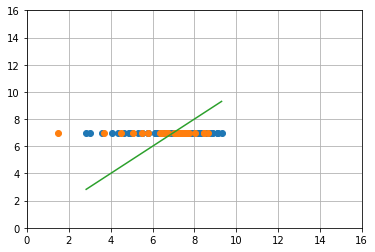

In [204]:
test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]]),decimals=3)
train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]]),decimals=3)

plt.plot(train_outputs, train_preds, 'o')
plt.plot(test_outputs, test_preds, 'o')
x = np.linspace(min(train_outputs), max(train_outputs), 500)
plt.plot(x, x)
plt.ylim(0,16)
plt.xlim(0,16)

plt.grid()

In [205]:
preds = new_model.predict([inputs[0:1, 0], inputs[0:1,1], inputs[0:1, 2], inputs[0:1,3]]) 
print (preds, outputs[0])

[[6.963171]] 7.35


MSE_KJ 0.7259606068042389


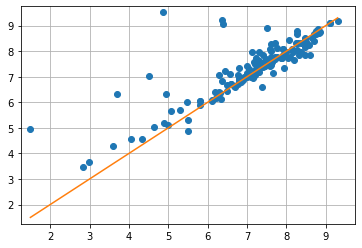

In [210]:
plt.plot(df['D (exp) [km/s]'], df['D_KJ [km/s]'], 'o')

x = np.linspace(min(df['D (exp) [km/s]']), max(df['D (exp) [km/s]']), 500)
plt.plot(x, x)
plt.ylim(1.25,9.75)
plt.xlim(1.25,9.75)

print('MSE_KJ',((df['D_KJ [km/s]'] - df['D (exp) [km/s]']) ** 2).mean() ** .5)

plt.grid()